In [13]:
from transformers import AutoProcessor, AutoModelForImageTextToText, TextStreamer
from PIL import Image
import requests
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import re
import json
from tqdm.auto import tqdm
import pandas as pd

In [14]:
ki67 = Path('/data2/shreyas/projects/PATHOLOGY-VLM/dataset/2023-03-03')
ki67_images = list(ki67.glob('*'))
ihc = Path('/data2/shreyas/projects/PATHOLOGY-VLM/dataset/2023-03-04')
ihc_images = list(ihc.glob('*'))

In [15]:
one_shot = """You are provided with an image showing Ki67 staining, your task is to analyze this image to assess the presence, proportion, and intensity of staining.
Please answer the following questions based solely on the provided image:
1. Is there any brown nuclear staining in this image? [yes/no]
2. If there is staining, calculate the approxiate proportion of cells that are stained?
3. If there is staining, grade the staining in levels [1,2,3] where 3 indicates intense brown staining and 1,2 are relative lower to 3.
The image can have multiple levels of staining

ONLY Return a JSON response in the following format:
{
    "brown_stain": yes OR no,
    "stain_proportion": float [Provide a float value between 0.0 and 1.0],
    "stain_levels": set[int] - set of all possible staining intensities (1,2,3) present in the image. 1:low, 2:medium, 3:high
    "report": string - a detailed descriptive report of the image and what you observe and summary of your findings in image.
}

Example:
"""

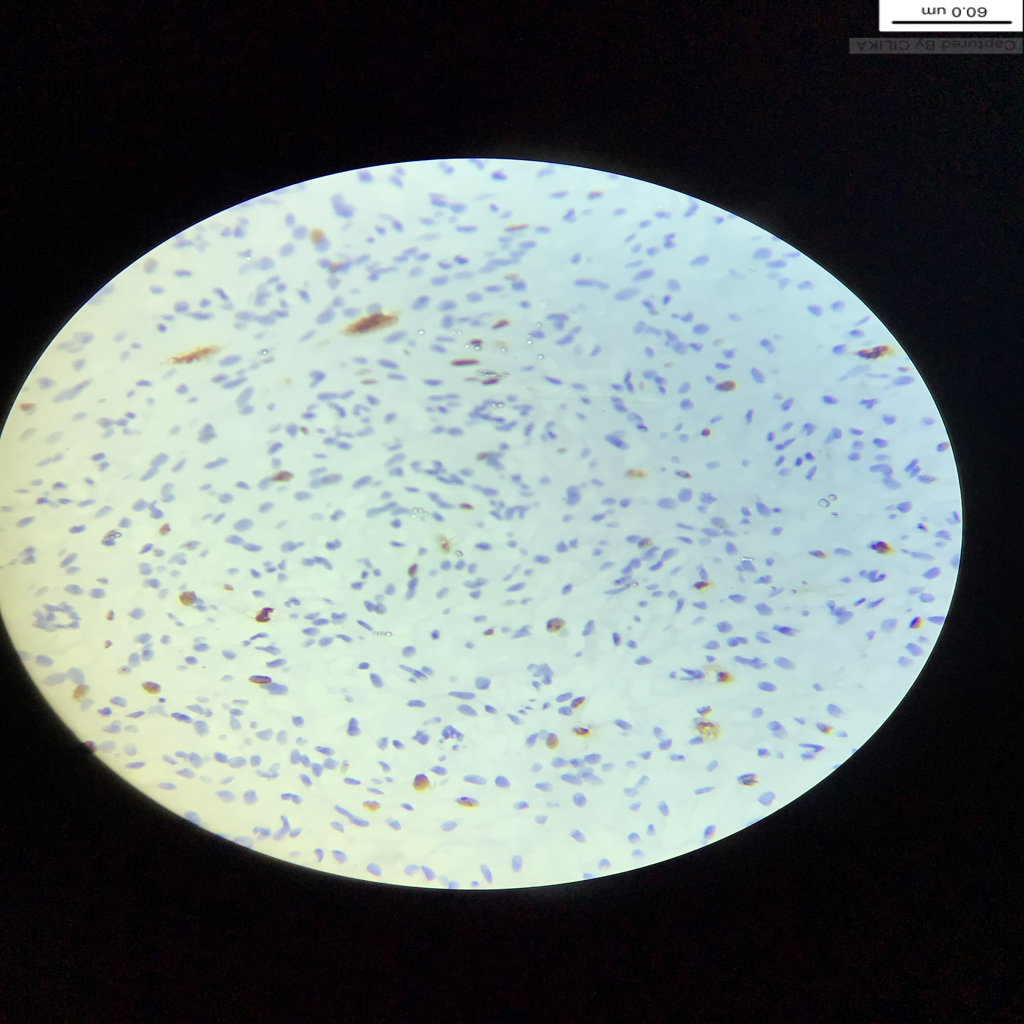

In [16]:
ex_im = Image.open('dataset/2023-03-03/77-40X-40X-1-00DX-2023-03-03-12-37-56.jpg').convert("RGB").resize((1024,1024))
ex_im

In [17]:
ex_report = """{
    "brown_stain": yes,
    "stain_proportion": 0.11,
    "stain_levels": [2,3]
    "report": string - the image has around 11% brown staining, the nuclei have moderate to intense staining,
}
"""

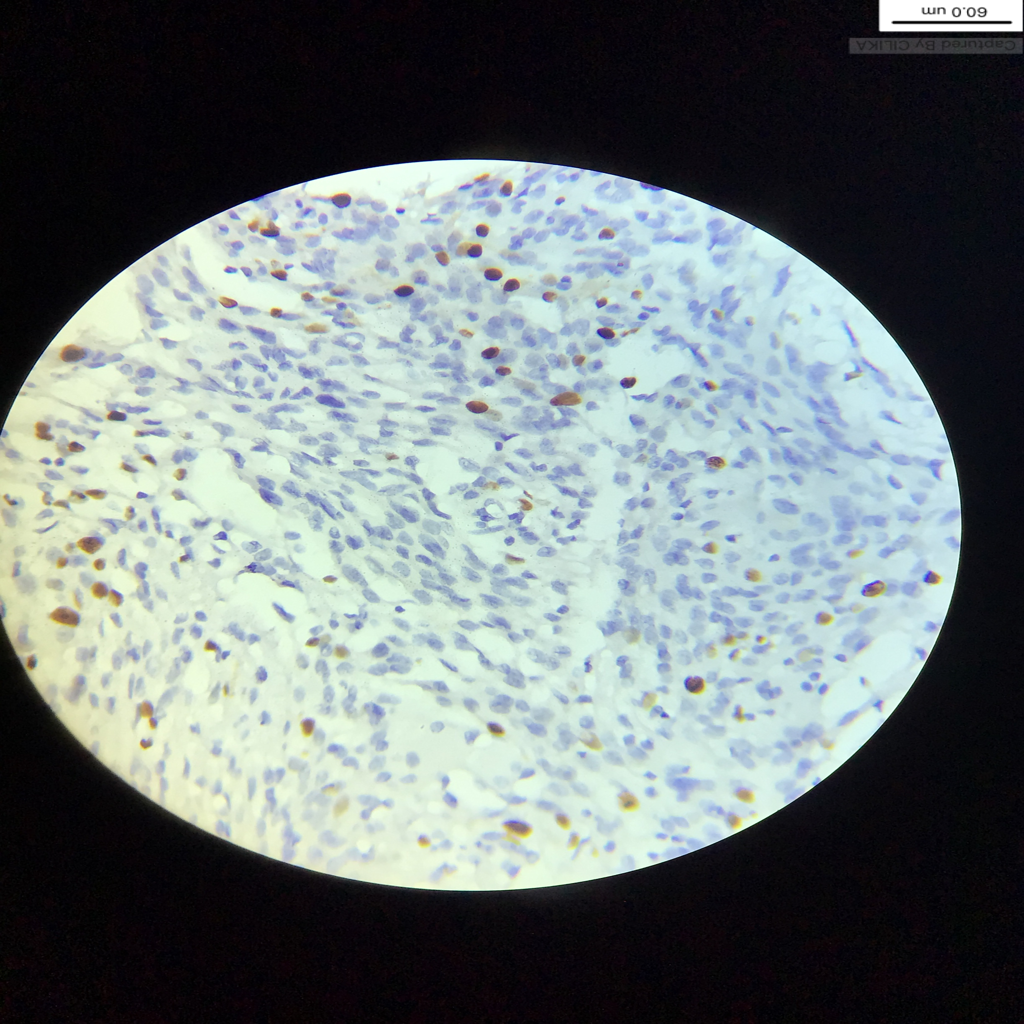

In [18]:
test_im = Image.open('/data2/shreyas/projects/PATHOLOGY-VLM/dataset/2023-03-03/89-40X-40X-1-00DX-2023-03-03-15-53-38.jpg').convert("RGB").resize((1024,1024))
test_im

In [19]:
messages = [
    {
        'role': 'system',
        "content": [{"type": "text", "text": "You are an expert pathologist."}]
    },
    {
        'role': 'user',
        'content': [
            {"type": "text", "text": one_shot},
            {"type": "image", "image": ex_im},
            {"type": "text", "text": f"Example Report: {ex_report}\nGenerate a report for the following image:"},
            {"type": "image", "image": test_im}
        ]
    }
]

In [20]:
model_id = "google/medgemma-4b-it"

model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [23]:
def predict(messages):
    inputs = processor.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=True,
        return_dict=True, return_tensors="pt"
    ).to(model.device, dtype=torch.bfloat16)
    processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id
    model.config.pad_token_id = model.config.eos_token_id

    input_len = inputs["input_ids"].shape[-1]

    with torch.inference_mode():
        generation = model.generate(
            **inputs,
            max_new_tokens=1024,
            do_sample=False,
            top_k=None,
            top_p=None,
        )
        generation = generation[0][input_len:]

    decoded = processor.decode(generation, skip_special_tokens=True)

    return decoded

In [24]:
predict(messages)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


'```json\n{\n    "brown_stain": yes,\n    "stain_proportion": 0.35,\n    "stain_levels": [2,3],\n    "report": "The image shows Ki67 staining. Approximately 35% of the cells exhibit brown nuclear staining. The staining intensity appears to be moderate to high."\n}\n```'